In [1]:
import torch

# 查看pytorch的版本
print(torch.__version__)

2.1.1


In [2]:
"""
 MNIST包含70,000张手写数字图像: 60,000张用于训练，10,000张用于测试。
 图像是灰度的，28x28像素的，并且居中的，以减少预处理和加快运行。
"""

'\n MNIST包含70,000张手写数字图像: 60,000张用于训练，10,000张用于测试。\n 图像是灰度的，28x28像素的，并且居中的，以减少预处理和加快运行。\n'

In [3]:
# torchvision专门用于图形处理的一个模板
from torchvision import datasets
from torchvision.transforms import ToTensor

# 下载训练数据集（包含训练图片+标签）
training_data = datasets.MNIST(  # MNIST 手写字训练集  http://yann.lecun.com/exdb/mnist/
    root="data",  # 数据集的根目录
    train=True,  # train为true就读取训练的数据集，但是下载的时候训练和测试数据集都会下载下来 true代表只读取训练数据集
    download=True,  # 下载
    transform=ToTensor(),  # 图片下载下来后需要转换成pytorch可以使用的数据类型 tensor 张量
)  # 对于pytorch库能够识别的数据一般是tensor张量

# datasets.MNIST的参数：
#   root(string)： 表示数据集的根目录，
#   train(bool, optional)： 如果为True，则从training.pt创建数据集，否则从test.pt创建数据集
#   download(bool, optional)： 如果为True，则从internet下载数据集并将其放入根目录。如果数据集已下载，则不会再次下载
#   transform(callable, optional)： 接收PIL图片并返回转换后版本图片的转换函数

In [4]:
'''下载测试数据集（包含训练图片+标签） '''
test_data = datasets.MNIST(
    root="data",
    train=False,  # 读取手写数据中的测试数据集
    download=True,
    transform=ToTensor(),
)

print(len(training_data))  # 60000 代表测试数据集有6万张图片以及标签

60000


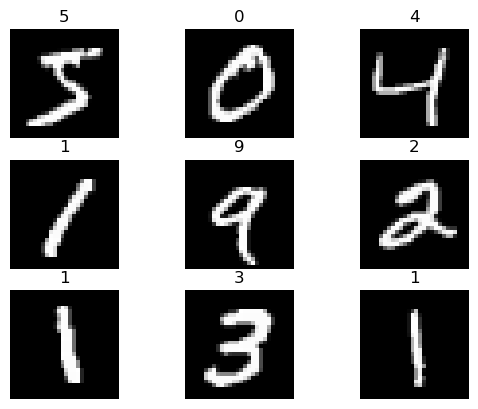

In [5]:
# 展示手写字图片 把训练数据集中的前9张图片展示一下
from matplotlib import pyplot as plt

figure = plt.figure()
for i in range(9):
    img, label = training_data[i]  #img图片 label标签（图片代表的数字结果）
    figure.add_subplot(3, 3, i + 1)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


In [6]:
'''创建数据DataLoader（数据加载器）
    batch_size:将数据集分成多份，每一份为batch_size个数据。
           优点：可以减少内存的使用，提高训练速度。
'''
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data,
                              batch_size=64)  # 64张图片为一个包，就是将电脑硬盘中的数据按64张图一个包 按照包批次放到GPU的内存中 如果电脑内存大  可以调大batch_size
test_dataloader = DataLoader(test_data, batch_size=64)
for X, y in test_dataloader:  # X是表示打包好的每一个数据包
    print(
        f"Shape of X [N, C, H, W]: {X.shape}")  # shape数据的形状 torch.Size([64, 1, 28, 28]) 64*1*28*28 这样的数据特征 有64张图片，每一张图片有28*28像素 组合成一张图片
    print(f"Shape of y: {y.shape} {y.dtype}")  # torch.Size([64]) torch.int64 y表示的是标签，标签也是64个数
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [7]:
'''判断当前设备是否支持GPU，其中mps是苹果m系列芯片的GPU。'''
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [8]:
''' 定义神经网络  '''

from torch import nn  # nn 神经网络模型


class NeuralNetwork(nn.Module):  #
    def __init__(self):  #python基础关于类
        super().__init__()
        self.flatten = nn.Flatten()  # 展开 将图片进行展开 图片实际上已经转换成行列数据 28*28 将其展开 Flatten将图片数据展开为一条线的形式
        self.hidden1 = nn.Linear(28 * 28,
                                 128)  # 线性的神经元 隐含层的神经元每一个都会接受到和输入层一样个数的权值也就是28*28  输出的结果128 也就是说经过隐含层后会输出给128个神经元
        self.hidden2 = nn.Linear(128, 256)  # 隐含层2 有128个输入 有256个输出
        self.out = nn.Linear(256, 10)  # 输出层  256个输入  10个输出（由当前需要的多分类的个数去决定  这边是要识别数字0-9 一共10个数字  所以是10个分类）

    # 将神经元连接起来 通过数据x将各个连接层连接起来
    def forward(self, x):  #x数输入数据
        x = self.flatten(x)  # 展开数据
        x = self.hidden1(x)
        x = torch.sigmoid(x)  # sigmoid 激活函数
        x = torch.relu(x)
        x = self.hidden2(x)
        # x = torch.sigmoid(x)
        x = torch.relu(x)
        x = self.out(x)
        return x


model = NeuralNetwork().to(device)  # 这个神经网络传入到GPU中 如果是CPU就会传递到CPU中,如果使用了GPU的话，这里面就使用了cuda命令
print(model)
# print(model.parameters())

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)


In [9]:

loss_fn = nn.CrossEntropyLoss()  #创建交叉熵损失函数对象，因为手写字识别中一共有10个数字，输出会有10个结果

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#创建一个优化器，SGD为随机梯度下降算法？？   Adam 自适应矩估计
#params：要训练的参数，一般我们传入的都是model.parameters()。
#lr：learning_rate学习率，也就是步长。


In [10]:
# 模型训练
def train(dataloader, model, loss_fn, optimizer):
    model.train()  # 进入训练模式
    # pytorch提供2种方式来切换训练和测试的模式，分别是：model.train() 和 model.eval()。
    # 一般用法是：在训练开始之前写上model.trian()，在测试时写上 model.eval() 。
    batch_size_num = 1
    for X, y in dataloader:  #其中batch为每一个数据的编号
        X, y = X.to(device), y.to(device)  #把训练数据集和标签传入cpu或GPU
        pred = model.forward(X)  #自动初始化 w权值
        loss = loss_fn(pred, y)  #通过交叉熵损失函数计算损失值loss
        # Backpropagation 进来一个batch的数据，计算一次梯度，更新一次网络
        optimizer.zero_grad()  #梯度值清零
        loss.backward()  #反向传播计算得到每个参数的梯度值
        optimizer.step()  #根据梯度更新网络参数

        loss = loss.item()  #获取损失值
        print(f"loss: {loss:>7f}  [number:{batch_size_num}]")
        batch_size_num += 1


# 参数：训练数据集、模型、损失函数、梯度下降算法
train(train_dataloader, model, loss_fn, optimizer)

loss: 2.330286  [number:1]
loss: 2.257444  [number:2]
loss: 2.327535  [number:3]
loss: 2.253344  [number:4]
loss: 2.290685  [number:5]
loss: 2.264870  [number:6]
loss: 2.265195  [number:7]
loss: 2.238167  [number:8]
loss: 2.272095  [number:9]
loss: 2.243832  [number:10]
loss: 2.223945  [number:11]
loss: 2.241041  [number:12]
loss: 2.202671  [number:13]
loss: 2.204970  [number:14]
loss: 2.178764  [number:15]
loss: 2.175669  [number:16]
loss: 2.167802  [number:17]
loss: 2.177572  [number:18]
loss: 2.095858  [number:19]
loss: 2.143020  [number:20]
loss: 2.112770  [number:21]
loss: 2.106479  [number:22]
loss: 2.092764  [number:23]
loss: 2.061916  [number:24]
loss: 2.069123  [number:25]
loss: 2.006964  [number:26]
loss: 1.921309  [number:27]
loss: 1.979387  [number:28]
loss: 1.923344  [number:29]
loss: 1.908138  [number:30]
loss: 1.882614  [number:31]
loss: 1.875158  [number:32]
loss: 1.847094  [number:33]
loss: 1.769330  [number:34]
loss: 1.766257  [number:35]
loss: 1.763301  [number:36]
l

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()  # 测试
    test_loss, correct = 0, 0
    with torch.no_grad():  #一个上下文管理器，关闭梯度计算。当你确认不会调用Tensor.backward()的时候。这可以减少计算所用内存消耗。
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model.forward(X)
            test_loss += loss_fn(pred, y).item()  #
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            a = (pred.argmax(1) == y)  #dim=1表示每一行中的最大值对应的索引号，dim=0表示每一列中的最大值对应的索引号
            b = (pred.argmax(1) == y).type(torch.float)  # 得到每一个数值的概率
    test_loss /= num_batches
    correct /= size
    print(f"Test result: \n Accuracy: {(100 * correct)}%, Avg loss: {test_loss}")


test(test_dataloader, model, loss_fn)

Test result: 
 Accuracy: 93.10000000000001%, Avg loss: 0.22679736135396988


In [ ]:
epochs = 10  # 模型训练10次，一般模型的训练需要进行多轮，一直持续到模型准确率无法提升了为止
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    # test(test_dataloader, model, loss_fn)
print("Done!")
test(test_dataloader, model, loss_fn)

#分析sigmiod，relu
# sgd，Adam

Epoch 1
-------------------------------
loss: 0.139462  [number:1]
loss: 0.116711  [number:2]
loss: 0.319282  [number:3]
loss: 0.304459  [number:4]
loss: 0.222518  [number:5]
loss: 0.113781  [number:6]
loss: 0.203933  [number:7]
loss: 0.359185  [number:8]
loss: 0.124845  [number:9]
loss: 0.353726  [number:10]
loss: 0.240142  [number:11]
loss: 0.218286  [number:12]
loss: 0.270870  [number:13]
loss: 0.468758  [number:14]
loss: 0.315589  [number:15]
loss: 0.248144  [number:16]
loss: 0.523221  [number:17]
loss: 0.632570  [number:18]
loss: 0.111968  [number:19]
loss: 0.465632  [number:20]
loss: 0.308103  [number:21]
loss: 0.483858  [number:22]
loss: 0.113764  [number:23]
loss: 0.248713  [number:24]
loss: 0.267336  [number:25]
loss: 0.163869  [number:26]
loss: 0.165982  [number:27]
loss: 0.196295  [number:28]
loss: 0.175304  [number:29]
loss: 0.090199  [number:30]
loss: 0.219809  [number:31]
loss: 0.140637  [number:32]
loss: 0.231378  [number:33]
loss: 0.131614  [number:34]
loss: 0.222394  [